In [1]:
import os
import json
import pickle
import numpy as np
import random
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

[Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/)

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

[ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv)

In [2]:
filename = "ratings_Patio_Lawn_and_Garden.csv"

with open(os.path.join("data", filename), "rb") as f:
    ratings = pd.read_csv(f, names=("user", "item", "rating", "timestamp"))
ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


In [3]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))

    n = len(set(ratings[item_key]))
    d = len(set(ratings[user_key]))
    print("Number of users:", d)
    print("Number of items:", n)
    print("Fraction nonzero:", len(ratings)/(n*d))
    print("Size of full X matrix (GB):", (n*d)*8/1e9)

    return n, d


n, d = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction nonzero: 1.3114269915944552e-05
Size of full X matrix (GB): 606.051274752


In [4]:
def create_X(ratings, n, d, user_key="user", item_key="item"):
    """
    Creates a sparse matrix using scipy.csr_matrix and mappers to relate indexes to items' id.
    
    Parameters:
    -----------
    ratings: pd.DataFrame
        the ratings to be stored in the matrix;
    n: int
        the number of items
    d: int
        the number of users
    user_key: string
        the column in ratings that contains the users id
    item_key: string
        the column in ratings that contains the items id
    
    Returns: (X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind)
    --------
    X: np.sparse
        the sparse matrix containing the ratings.
    user_mapper: dict
        stores the indexes of the users - the user_id is the key;
    item_mapper: dict
        stores the indexes of the items - the item_id is the key;
    user_inverse_mapper: dict
        stores the user id - the user index is the key;
    item_inverse_mapper: dict
        stores the item id - the item index is the key;
    user_ind: list
        indexes of the users (in the order they are in ratings);
    item_ind: list
        indexes of the items;
    """
    
    user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(d))))
    item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(n))))

    user_inverse_mapper = dict(zip(list(range(d)), np.unique(ratings[user_key])))
    item_inverse_mapper = dict(zip(list(range(n)), np.unique(ratings[item_key])))

    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]

    X = sparse_matrix((ratings["rating"], (item_ind, user_ind)), shape=(n,d))
    
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind

X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(ratings, n, d)

In [5]:
# sanity check
print(X.shape) # should be number of items by number of users
print(X.nnz)   # number of nonzero elements -- should equal number of ratings
print(f"Using sparse matrix data structure, the size of X is: {X.data.nbytes/1e6}mb")

(105984, 714791)
993490
Using sparse matrix data structure, the size of X is: 7.94792mb


In [18]:
def get_links(index, prefix, mapper):
    
    get_id = mapper[index]
    link = prefix + str(get_id)
    display(HTML('<a href="%s">%s</a>' % (link, link)))

In [19]:
amz_prefix = 'https://www.amazon.com/dp/'

In [20]:
print('The item with the most reviews:')
get_links(np.argmax(X.getnnz(axis=1)), amz_prefix, item_inverse_mapper)
print('The item with the most total stars:')
get_links(np.argmax(np.squeeze(np.asarray(X.sum(axis=1)))), amz_prefix, item_inverse_mapper)
print('The item with the lowest average stars:')
get_links(np.argmin(np.squeeze(np.asarray(X.sum(axis=1)))/X.getnnz(axis=1)), amz_prefix, item_inverse_mapper)

The item with the most reviews:


The item with the most total stars:


The item with the lowest average stars:


In [16]:
def make_hist(var, xlab, ylab, title):
    
    plt.hist(var)
    plt.yscale('log', nonposy='clip')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

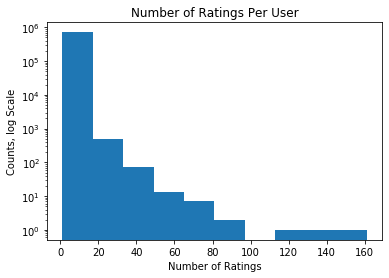

In [24]:
make_hist(X.getnnz(axis=0), 'Number of Ratings', 'Counts, log Scale', 'Number of Ratings Per User')

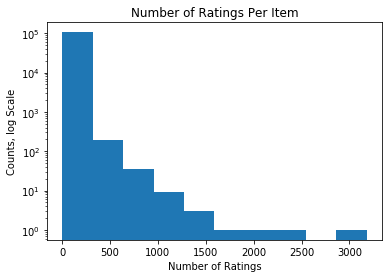

In [25]:
make_hist(X.getnnz(axis=1), 'Number of Ratings', 'Counts, log Scale', 'Number of Ratings Per Item')

In [26]:
grill_spatula = "B00IJB5MCS"
grill_spatula_ind = item_mapper[grill_spatula]
grill_spatula_vec = X[grill_spatula_ind]

In [28]:
def get_nn_links(X, n_neighbors, metric, start, prefix, mapper):
    
    indexes = nn_fitter(X, n_neighbors, metric, start)
    links = [prefix + mapper[i] for i in indexes]
    return indexes, [display(HTML('<a href="%s">%s</a>' % (link, link))) for link in links[1:]]

In [20]:
def nn_fitter(X, n_neighbors, metric, start):
    
    neigh = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    neigh.fit(X)
    indexes = neigh.kneighbors(start)[1][0]
    
    return indexes

In [29]:
indexes_eu, _ = get_nn_links(X, 7, 'minkowski', grill_spatula_vec, amz_prefix, item_inverse_mapper)

In [30]:
neigh = NearestNeighbors(n_neighbors=7, metric='cosine')
neigh.fit(X)
indexes_cos = neigh.kneighbors(grill_spatula_vec)[1][0]
links_cos = ['https://www.amazon.com/dp/' + item_inverse_mapper[i] for i in indexes_cos]
[display(HTML('<a href="%s">%s</a>' % (link, link))) for link in links_cos[1:]]

[None, None, None, None, None, None]

In [31]:
indexes_cos, _ = get_nn_links(X, 7, 'cosine', grill_spatula_vec, amz_prefix, item_inverse_mapper)

In [32]:
total_stars = np.squeeze(np.asarray(X.sum(axis=1)))
print('Euclidean distance: ')
for i in indexes_eu[1:]:
    print('Item:', item_inverse_mapper[i], 'with', total_stars[i], 'total stars')

print()

print('Cosine similarity: ')

for i in indexes_cos[1:]:
    print('Item:', item_inverse_mapper[i], 'with', total_stars[i], 'total stars')

Euclidean distance: 
Item: B00IJB4MLA with 205.0 total stars
Item: B00GMXARY8 with 1.0 total stars
Item: B00876SOD4 with 1.0 total stars
Item: B00604ZA5K with 1.0 total stars
Item: B0087CIBQS with 1.0 total stars
Item: B00605Y348 with 1.0 total stars

Cosine similarity: 
Item: B00IJB8F3G with 438.0 total stars
Item: B00IJB4MLA with 205.0 total stars
Item: B00EF45AHU with 311.0 total stars
Item: B00CFM0P7Y with 1244.0 total stars
Item: B00EF3YF0Y with 513.0 total stars
Item: B00EU1RIVO with 43.0 total stars


In [33]:
def get_stars(total_stars, indexes, mapper):
    
    for i in indexes[1:]:
        print('Item:', mapper[i], 'with', total_stars[i], 'total stars')

In [34]:
total_stars = np.squeeze(np.asarray(X.sum(axis=1)))

In [35]:
print('Euclidean distance: ')
get_stars(total_stars, indexes_eu, item_inverse_mapper)

Euclidean distance: 
Item: B00IJB4MLA with 205.0 total stars
Item: B00GMXARY8 with 1.0 total stars
Item: B00876SOD4 with 1.0 total stars
Item: B00604ZA5K with 1.0 total stars
Item: B0087CIBQS with 1.0 total stars
Item: B00605Y348 with 1.0 total stars


In [36]:
print('Cosine similarity: ')
get_stars(total_stars, indexes_cos, item_inverse_mapper)

Cosine similarity: 
Item: B00IJB8F3G with 438.0 total stars
Item: B00IJB4MLA with 205.0 total stars
Item: B00EF45AHU with 311.0 total stars
Item: B00CFM0P7Y with 1244.0 total stars
Item: B00EF3YF0Y with 513.0 total stars
Item: B00EU1RIVO with 43.0 total stars


In [39]:
def transform(X, n_components, vec):
    
    svd = TruncatedSVD(n_components=n_components)
    Z = svd.fit_transform(X)
    transed = svd.transform(vec)
    
    return Z, transed

In [40]:
Z, transed_grill = transform(X, 10, grill_spatula_vec)

In [41]:
indexes_svd, _ = get_nn_links(Z, 7, 'euclidean', transed_grill, amz_prefix, item_inverse_mapper)

In [42]:
get_stars(total_stars, indexes_svd, item_inverse_mapper)

Item: B00IJB8F3G with 438.0 total stars
Item: B00C5RS7A6 with 39.0 total stars
Item: B002CAB2KS with 57.0 total stars
Item: B004IEBUBW with 47.0 total stars
Item: B0012XS33K with 198.0 total stars
Item: B007PZ4ILK with 274.0 total stars


In [103]:
for i in [10, 50, 100, 200, 300]:
    print('n_components=', i)
    movie_Z, transed_movie = transform(movie_X, i, toy_story_vec)
    index_movie_trans = nn_fitter(movie_Z, 7, 'euclidean', transed_movie)
    
    movies = [movie_info.loc[movie_inverse_mapper[i]][0] for i in index_movie_trans[1:]]
    movie_stars = np.asarray(movie_X[index_movie_trans].sum(axis=1)[1:]).flatten()

    for m, s in zip(movies, movie_stars):
    
        print(m, 'total stars:',s)
        
    print()

n_components= 10
Independence Day (a.k.a. ID4) (1996) total stars: 696.0
Back to the Future (1985) total stars: 690.5
Jurassic Park (1993) total stars: 892.5
Aladdin (1992) total stars: 694.0
Mission: Impossible (1996) total stars: 573.0
Groundhog Day (1993) total stars: 564.0

n_components= 50
Toy Story 2 (1999) total stars: 374.5
Independence Day (a.k.a. ID4) (1996) total stars: 696.0
Willy Wonka & the Chocolate Factory (1971) total stars: 461.0
Groundhog Day (1993) total stars: 564.0
Mission: Impossible (1996) total stars: 573.0
Back to the Future (1985) total stars: 690.5

n_components= 100
Mission: Impossible (1996) total stars: 573.0
Toy Story 2 (1999) total stars: 374.5
Independence Day (a.k.a. ID4) (1996) total stars: 696.0
Twister (1996) total stars: 408.5
Willy Wonka & the Chocolate Factory (1971) total stars: 461.0
Mask, The (1994) total stars: 500.0

n_components= 200
Toy Story 2 (1999) total stars: 374.5
Independence Day (a.k.a. ID4) (1996) total stars: 696.0
Mission: Impo

In [14]:
svd21 = TruncatedSVD(n_components=10)
Z21 = svd21.fit_transform(movie_X)
re21 = svd21.inverse_transform(Z21[0,:].reshape(1, 10))

In [15]:
re21[0, 5]

3.206149566966723

In [14]:
svd312 = TruncatedSVD(n_components=10)
Z312 = svd312.fit_transform(X)
re312 = svd312.inverse_transform(Z312[9,:].reshape(1, 10))

In [15]:
re312[0, 5]

2.9347760657819253e-21